In [ ]:

# ==== CONFIG ====
DATA_PATH = r"C:\Users\Bharath\AIDM SEM 3\MATH\project\Epileptic Seizure Recognition.csv"

# Optional: where to save outputs (cleaned.csv, models, figures)
import os
BASE_DIR = os.path.dirname(DATA_PATH) if os.path.isfile(DATA_PATH) else os.path.dirname(DATA_PATH)
OUT_DIR = os.path.join(BASE_DIR, "outputs_seizure_ml")
os.makedirs(OUT_DIR, exist_ok=True)
print("Base directory:", BASE_DIR)
print("Outputs directory:", OUT_DIR)


In [3]:

# ==== IMPORTS ====
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve, matthews_corrcoef, cohen_kappa_score,
    balanced_accuracy_score
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from joblib import dump

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True



> **Note**: `shap` is optional but recommended for richer XAI; if it's not installed, the notebook will gracefully skip SHAP plots.  
> Uncomment the following cell to install (requires internet).


In [4]:

pip install shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")
df.head()


Shape: (11500, 180)
Columns: ['Unnamed', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'] ...


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


Target column: y


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
5556,X6.V1.83,-5,-13,-4,3,4,4,12,28,45,...,-54,-64,-49,-34,-17,-18,-10,-10,-15,5
1570,X17.V1.921,-39,-32,-21,-14,-9,8,38,67,89,...,-14,-71,-123,-143,-154,-129,-94,-46,1,4
2582,X7.V1.871,115,106,39,-4,-10,-10,-22,-20,1,...,-55,-29,-14,-18,-29,-29,-15,-20,-10,4
4948,X23.V1.80,-6,-14,-25,-24,-10,9,26,54,61,...,-7,-24,-9,32,65,97,100,88,80,5
7089,X17.V1.50,59,56,71,58,66,52,34,17,-2,...,-29,3,38,62,65,40,18,5,-6,5
7517,X3.V1.883,62,57,56,63,66,80,74,68,57,...,84,79,79,76,80,90,94,86,76,2
7458,X15.V1.993,-92,-71,-51,-32,-20,16,34,39,37,...,-61,-56,-49,-47,-39,-37,-32,-25,-26,2
10473,X13.V1.502,-70,-67,-61,-59,-62,-61,-62,-66,-70,...,38,37,33,32,19,18,6,2,-6,3


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed,11500,11500,X16.V1.210,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X1,11500.0,NaN,NaN,NaN,-11.581391,165.626284,-1839.0,-54.0,-8.0,34.0,1726.0
X2,11500.0,NaN,NaN,NaN,-10.911565,166.059609,-1838.0,-55.0,-8.0,35.0,1713.0
X3,11500.0,NaN,NaN,NaN,-10.18713,163.524317,-1835.0,-54.0,-7.0,36.0,1697.0
X4,11500.0,NaN,NaN,NaN,-9.143043,161.269041,-1845.0,-54.0,-8.0,36.0,1612.0
...,...,...,...,...,...,...,...,...,...,...,...
X175,11500.0,NaN,NaN,NaN,-13.045043,164.241019,-1863.0,-56.0,-9.0,34.0,1958.0
X176,11500.0,NaN,NaN,NaN,-12.70513,162.895832,-1781.0,-55.0,-9.0,34.0,2047.0
X177,11500.0,NaN,NaN,NaN,-12.426,162.886311,-1727.0,-55.0,-9.0,34.0,2047.0
X178,11500.0,NaN,NaN,NaN,-12.195652,164.852015,-1829.0,-55.0,-9.0,34.0,1915.0


,missing_count
Unnamed,0
X1,0
X2,0
X3,0
X4,0
...,...
X175,0
X176,0
X177,0
X178,0


Duplicate rows: 0


,count,proportion
y,,
1,2300,0.2
2,2300,0.2
3,2300,0.2
4,2300,0.2
5,2300,0.2


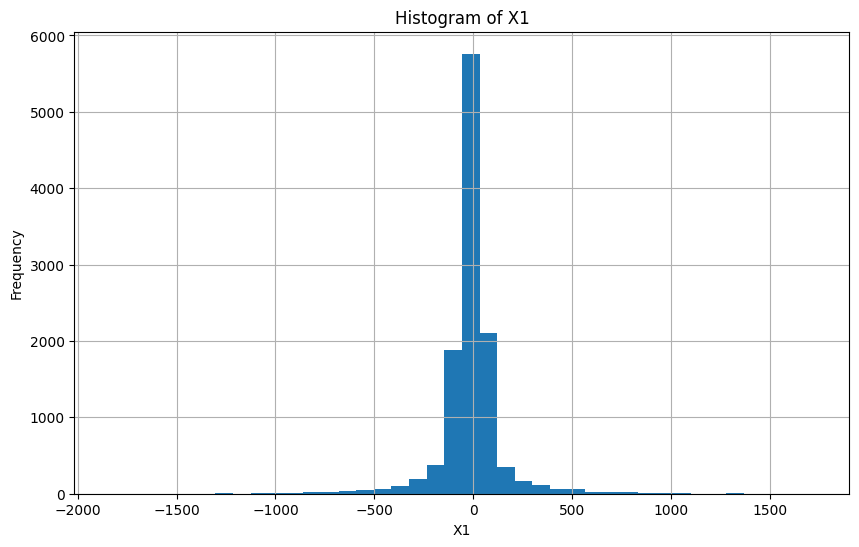

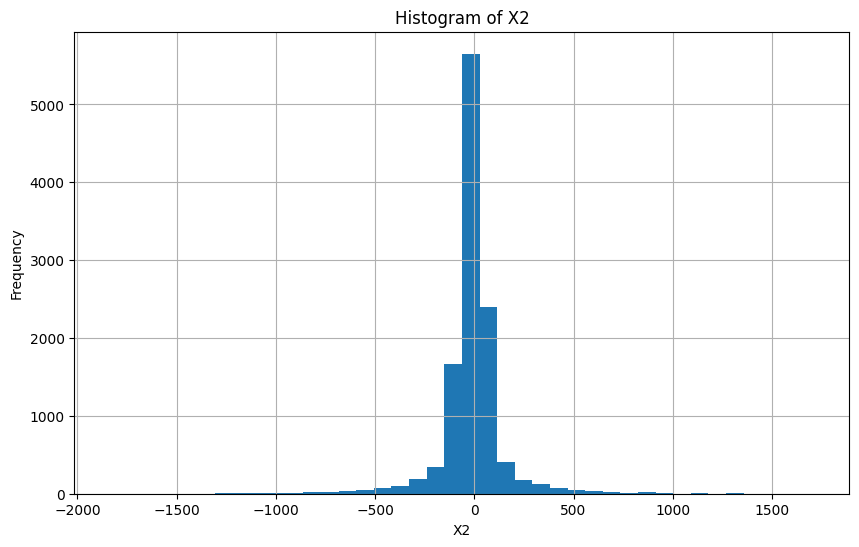

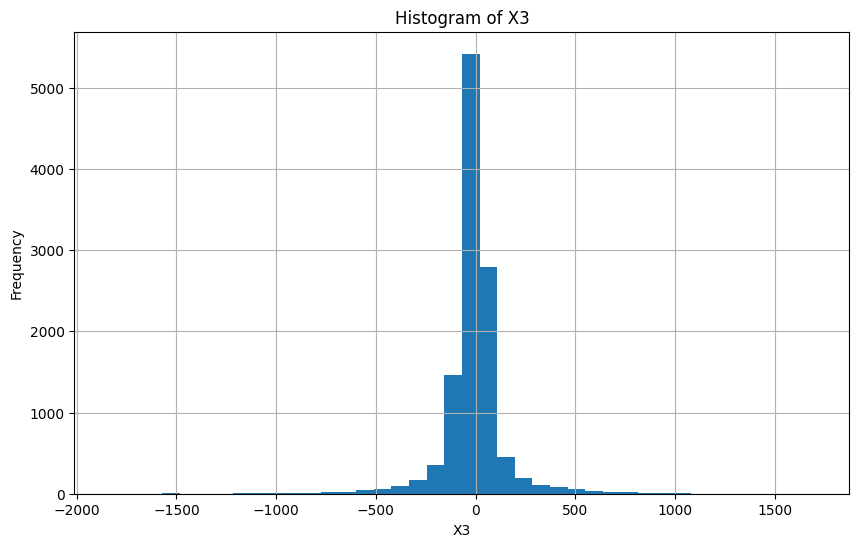

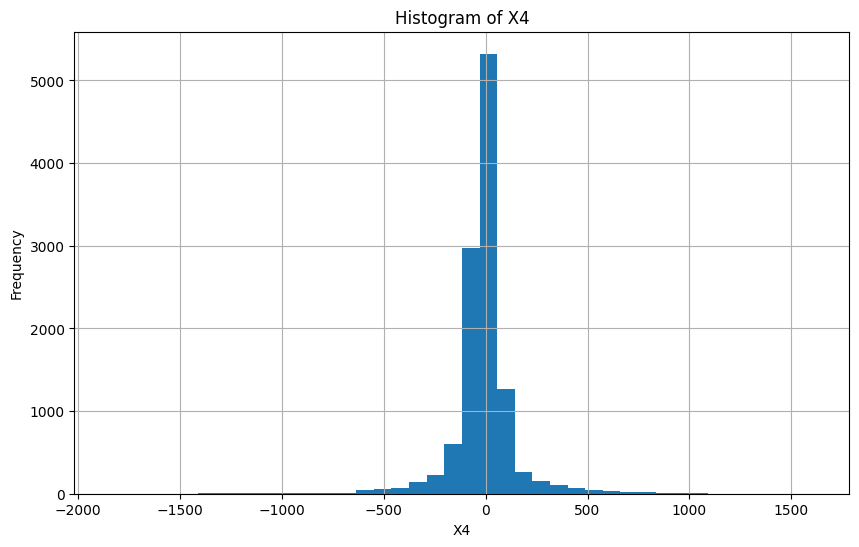

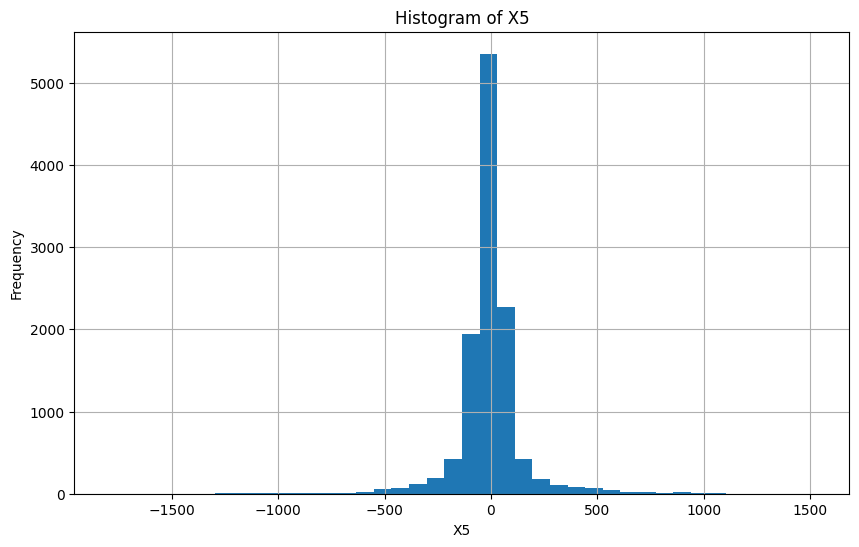

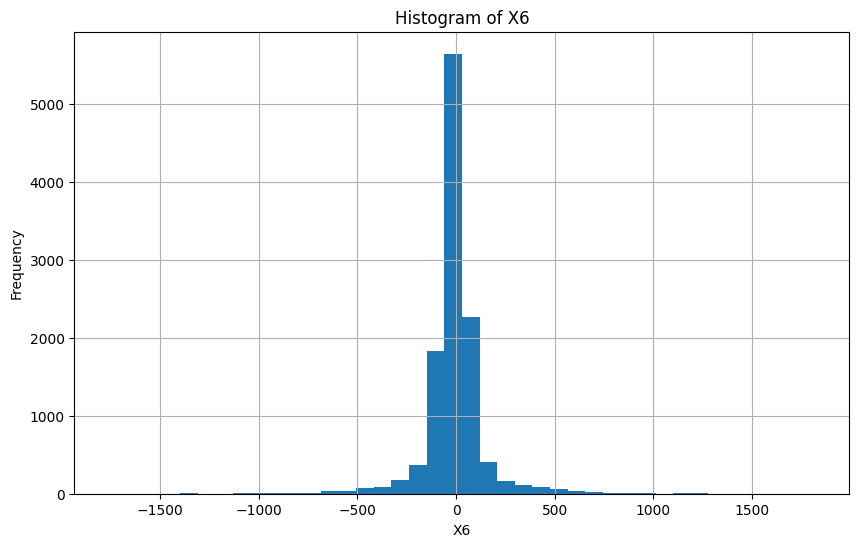

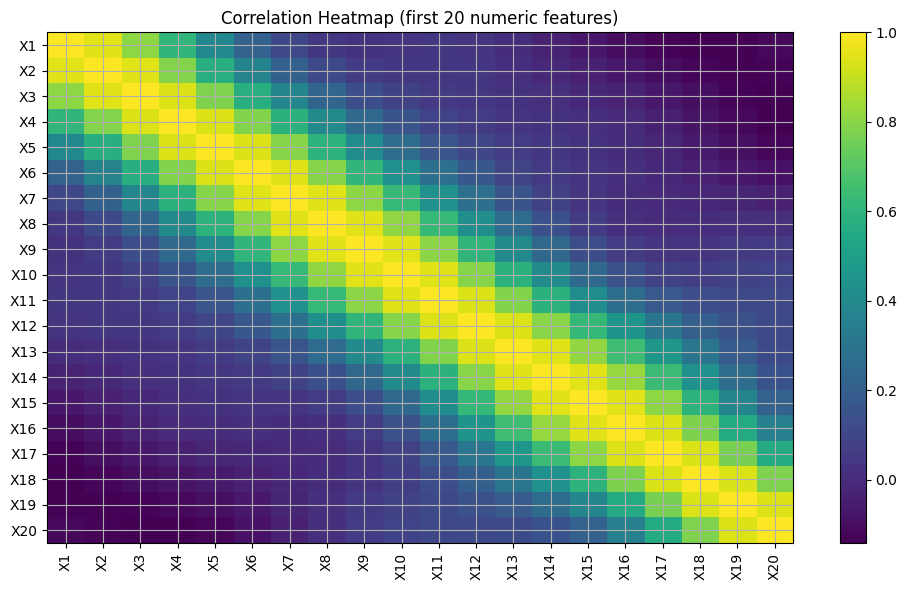

In [6]:

# Detect target column (commonly 'y'); default to last column if needed
target_candidates = [c for c in df.columns if c.strip().lower() in ["y","target","label"]]
target_col = target_candidates[0] if target_candidates else df.columns[-1]
print("Target column:", target_col)

# Basic structure
display(df.sample(8, random_state=42))
display(df.describe(include="all").T)

# Missing values, duplicates
display(pd.DataFrame({"missing_count": df.isna().sum()}))
print("Duplicate rows:", df.duplicated().sum())

# Class distribution
class_counts = df[target_col].value_counts().sort_index()
class_props = (class_counts / len(df)).rename("proportion")
display(pd.concat([class_counts.rename("count"), class_props], axis=1))

# Quick histograms for first few numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols[:6]:
    ax = df[col].hist(bins=40)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col); ax.set_ylabel("Frequency")
    plt.show()

# Correlation heatmap (first 20 features for readability)
subset = num_cols[:20]
corr = df[subset].corr()
plt.imshow(corr, aspect="auto")
plt.title("Correlation Heatmap (first 20 numeric features)")
plt.colorbar()
plt.xticks(range(len(subset)), subset, rotation=90)
plt.yticks(range(len(subset)), subset)
plt.tight_layout()
plt.show()


In [8]:
# Drop index-like 'Unnamed' columns
to_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
df_ = df.drop(columns=to_drop).copy()

# Ensure target name is 'y'
if 'y' not in df_.columns:
    df_.rename(columns={df_.columns[-1]: 'y'}, inplace=True)

# Keep numeric features + target
num_cols = df_.select_dtypes(include=[np.number]).columns.tolist()
if 'y' in num_cols:
    num_cols.remove('y')

X = df_[num_cols].copy()
y = df_['y'].copy()

# ✅ Convert 5-class target into binary: seizure (1) vs non-seizure (0)
y = (y == 1).astype(int)

# Impute any missing numeric values by median (defensive)
X = X.fillna(X.median(numeric_only=True))

# Scale + PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original features:", X.shape[1])
print("Reduced features after PCA:", X_pca.shape[1])

# Combine PCA features back with target into a cleaned DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
cleaned = X_pca_df.copy()
cleaned['y'] = y.values

# Drop duplicates if any
cleaned = cleaned.drop_duplicates()

# Save cleaned.csv next to the raw file
clean_path = os.path.join(OUT_DIR, "cleaned.csv")
cleaned.to_csv(clean_path, index=False)
print("Saved:", clean_path)

cleaned.head()



Original features: 178
Reduced features after PCA: 39
Saved: C:\Users\Srisha\AIDM SEM 3\MATH\project\outputs_seizure_ml\cleaned.csv


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,y
0,0.137475,-1.146419,-0.836893,0.071085,0.177048,-0.825731,-0.777044,0.337638,2.744494,-0.734679,...,2.154933,-1.053161,0.090869,0.254414,-0.225816,1.055100,-0.320229,0.195361,-0.102763,0
1,1.703794,-3.643195,-6.153822,-8.033432,-4.549536,5.892971,-3.758370,-5.804916,4.187441,11.192247,...,7.613729,-5.082526,2.786232,1.832683,2.158849,-2.594621,-0.218890,0.437192,-3.813345,1
2,-0.495650,-0.261660,-0.931210,0.663789,-1.587618,-1.604942,0.880830,-1.591959,-0.400873,-1.435073,...,-0.027333,-0.946955,-0.827331,-0.611872,0.389295,0.490630,0.015729,-0.180175,0.048221,0
3,0.174219,0.249557,0.073646,0.108047,-1.615415,-3.136337,0.559638,-3.032901,-0.222729,-1.465921,...,-0.162047,0.002372,0.053858,-0.205829,-0.160254,-0.048781,0.088260,0.201175,0.139328,0
4,0.239163,0.117304,-0.486502,0.530629,-0.187739,-0.371186,0.045861,0.481596,-0.094907,0.541482,...,0.399276,-0.100645,0.334393,0.155918,-0.114335,-0.262911,-0.916693,0.658297,-0.122812,0


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA - keep 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original features:", X.shape[1])
print("Reduced features:", X_pca.shape[1])


Original features: 178
Reduced features: 39


In [11]:
from sklearn.model_selection import train_test_split

# Use PCA-reduced features
X = X_pca
y = cleaned['y'].values   # binary labels (0 = non-seizure, 1 = seizure)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original features:", X.shape[1] + 1)  # +1 for target
print("Reduced features after PCA:", X.shape[1])
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Original features: 40
Reduced features after PCA: 39
Train samples: 9200
Test samples: 2300


Training (binary): SVM_RBF


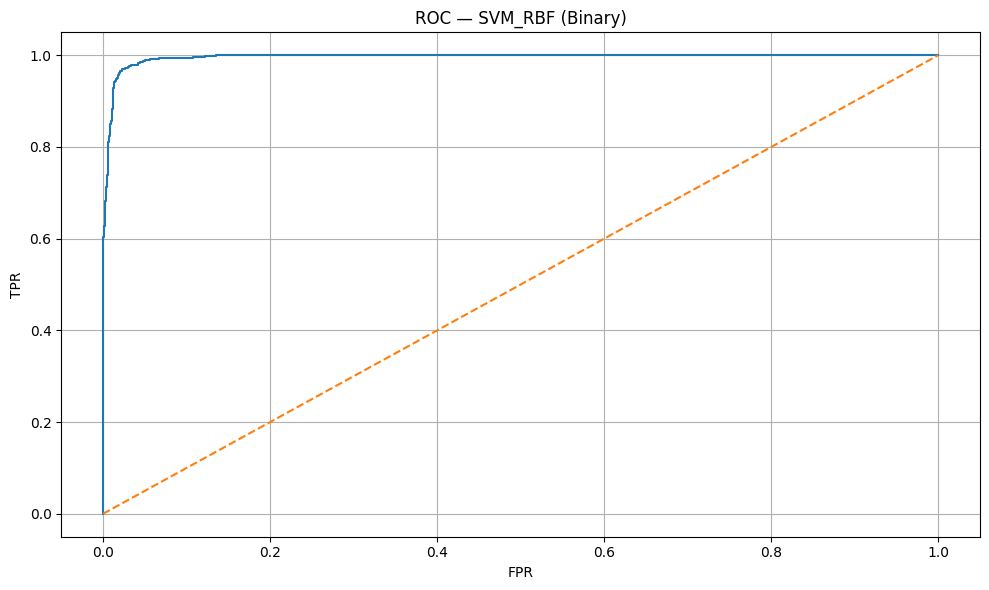

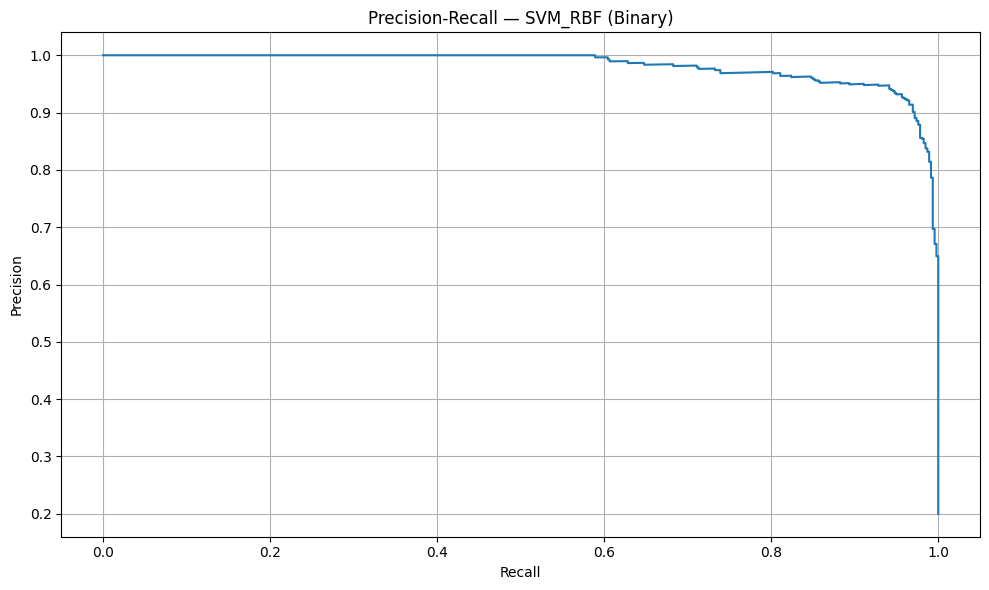

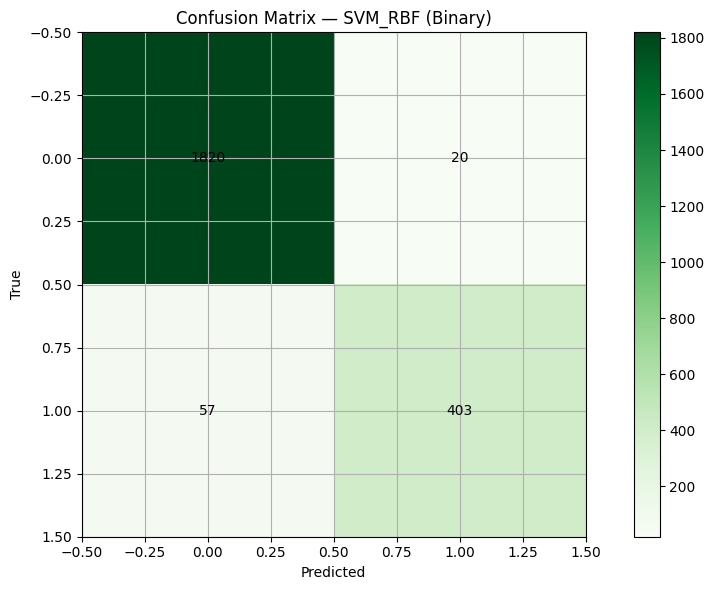

Classification Report — SVM_RBF (Binary)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1840
           1       0.95      0.88      0.91       460

    accuracy                           0.97      2300
   macro avg       0.96      0.93      0.95      2300
weighted avg       0.97      0.97      0.97      2300

Training (binary): LogisticRegression


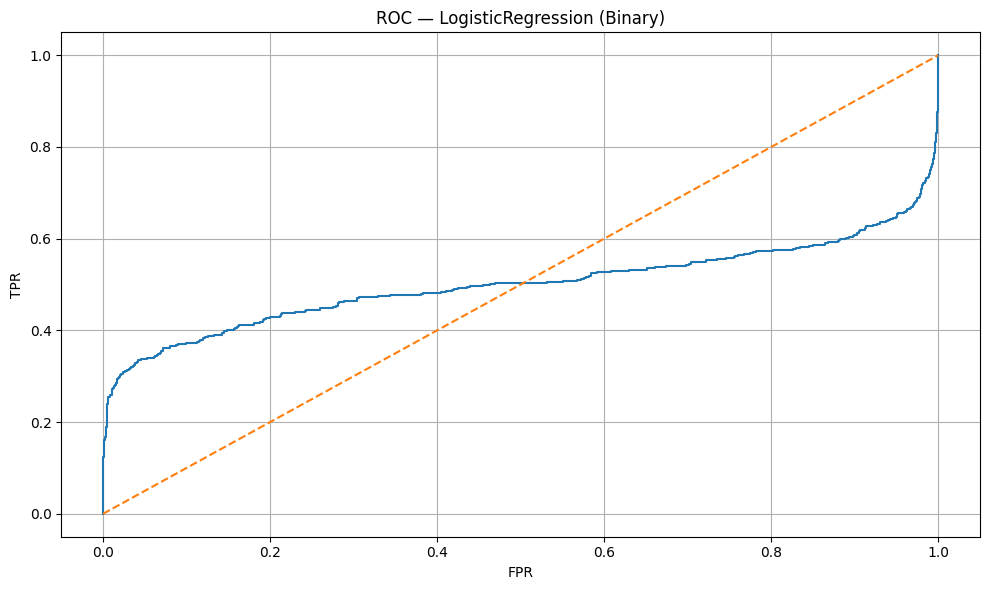

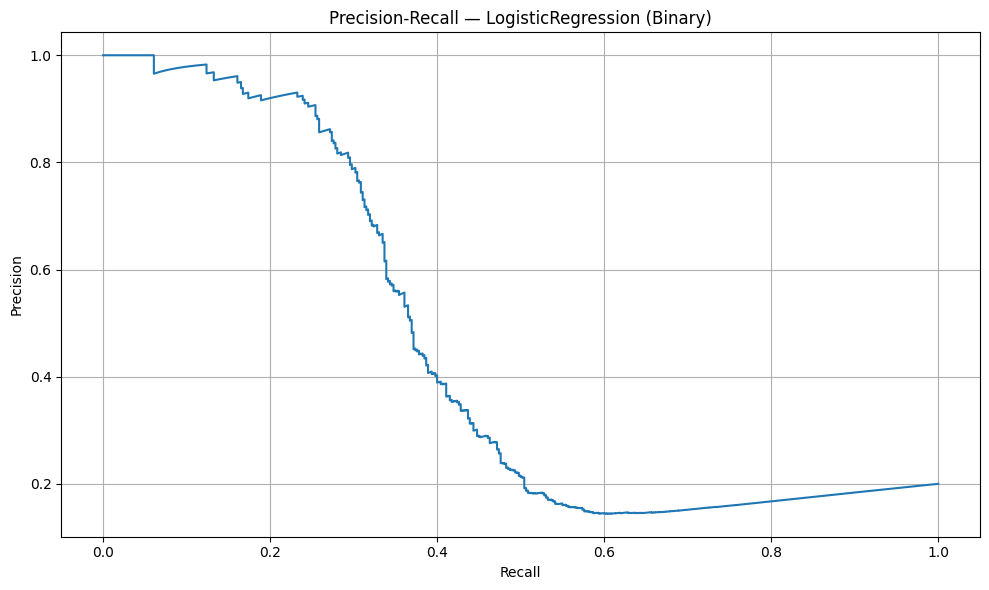

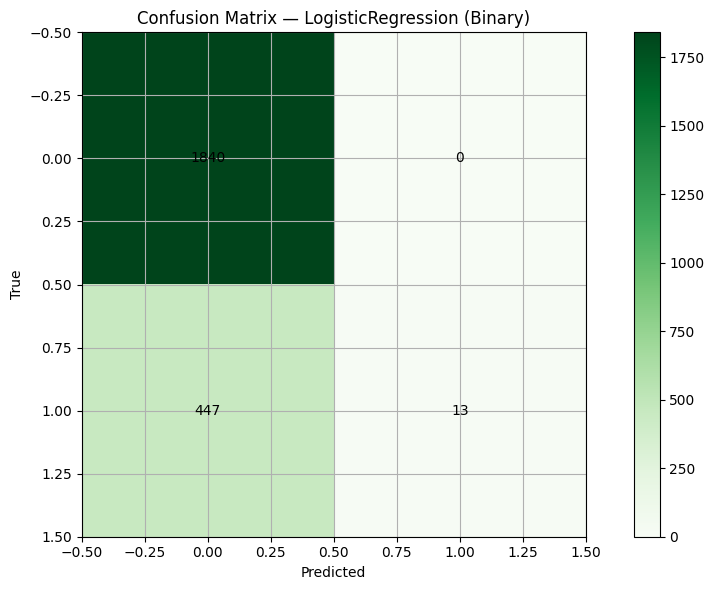

Classification Report — LogisticRegression (Binary)
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1840
           1       1.00      0.03      0.05       460

    accuracy                           0.81      2300
   macro avg       0.90      0.51      0.47      2300
weighted avg       0.84      0.81      0.72      2300

Training (binary): RandomForest


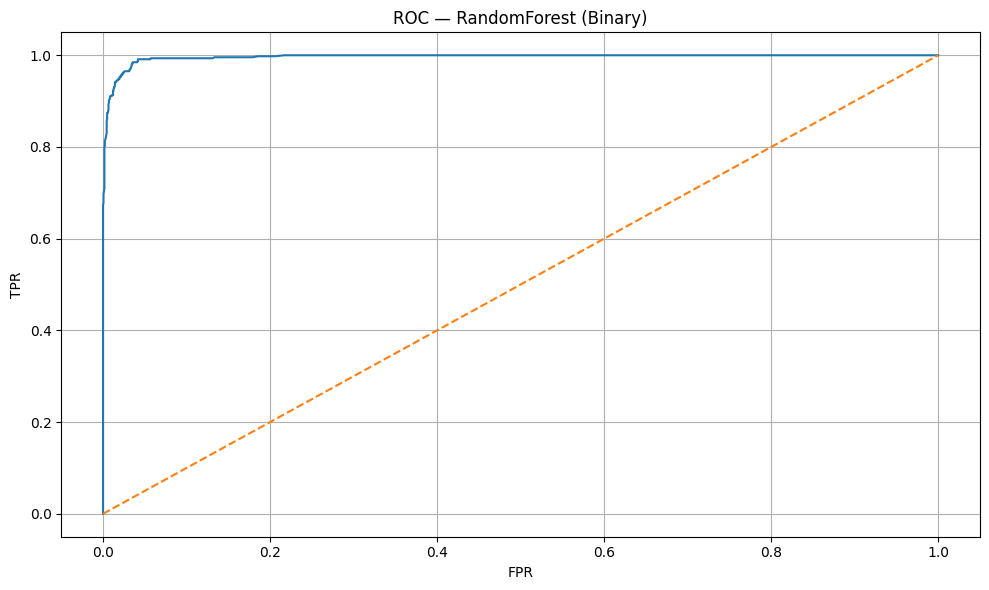

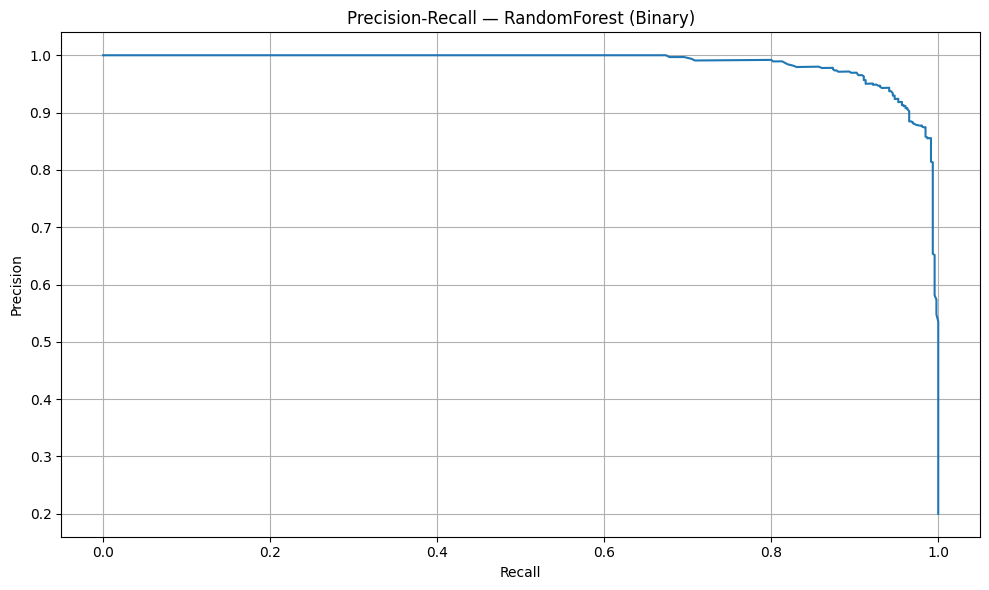

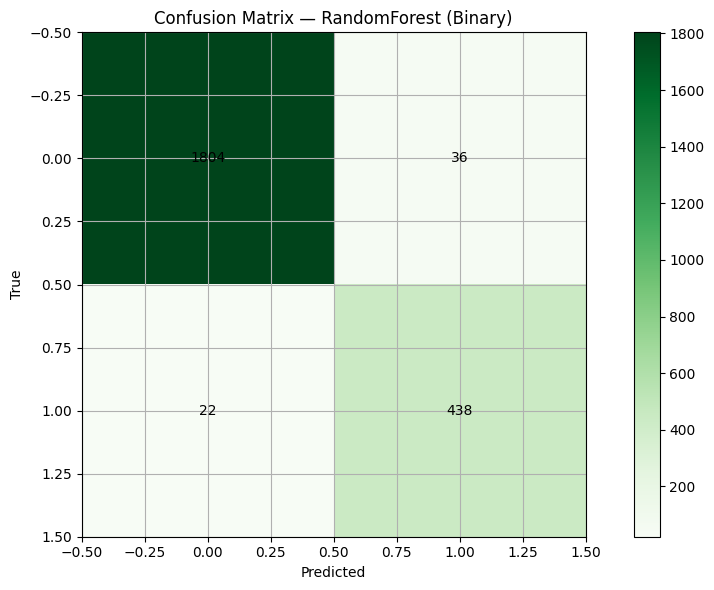

Classification Report — RandomForest (Binary)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1840
           1       0.92      0.95      0.94       460

    accuracy                           0.97      2300
   macro avg       0.96      0.97      0.96      2300
weighted avg       0.98      0.97      0.97      2300

Training (binary): GradientBoosting


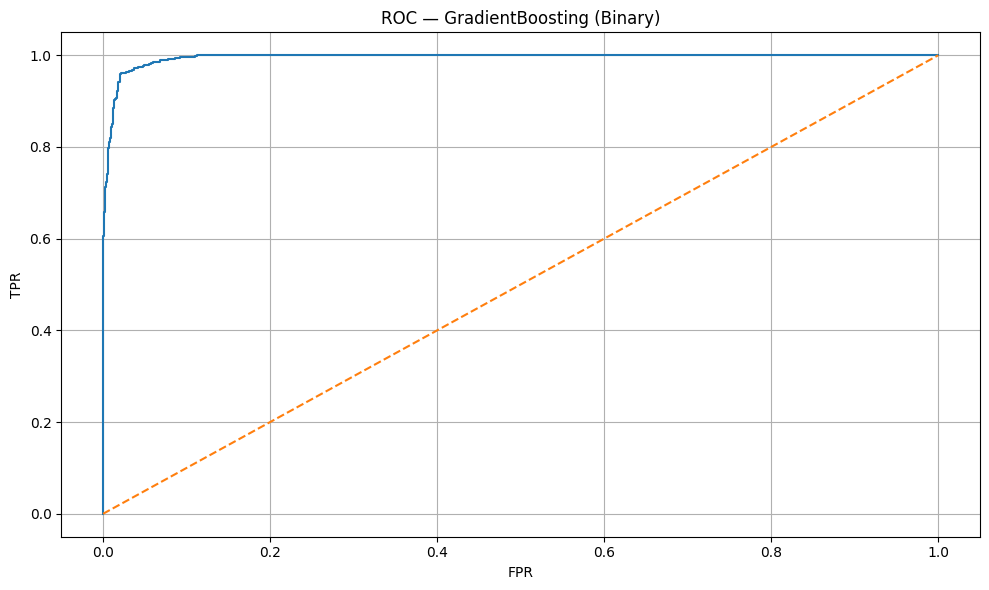

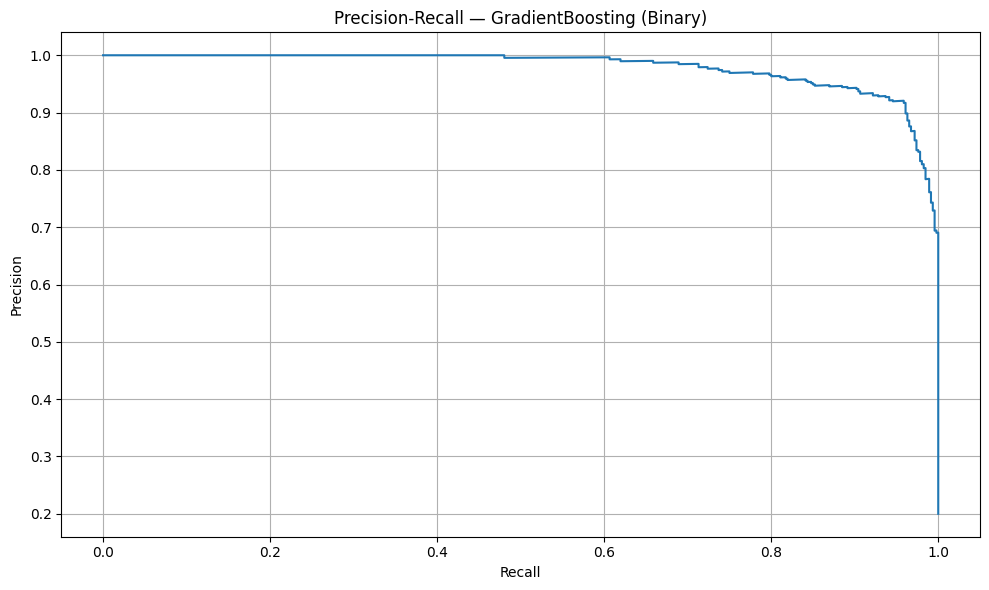

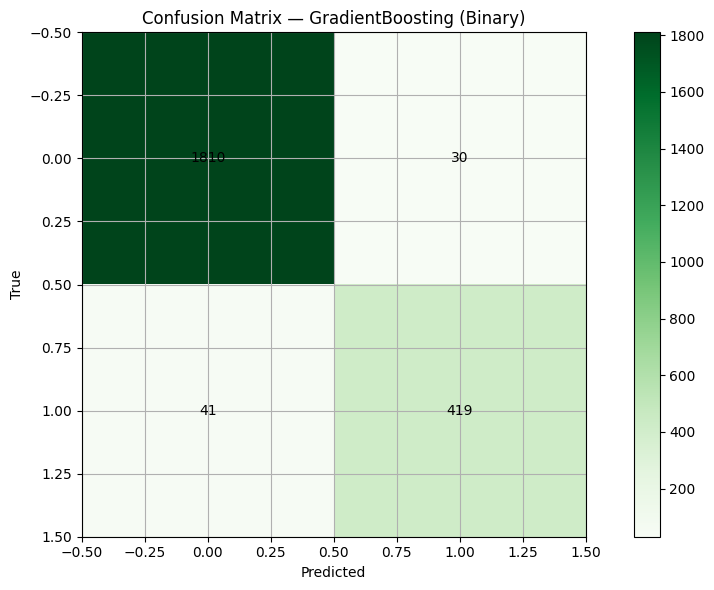

Classification Report — GradientBoosting (Binary)
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1840
           1       0.93      0.91      0.92       460

    accuracy                           0.97      2300
   macro avg       0.96      0.95      0.95      2300
weighted avg       0.97      0.97      0.97      2300

Training (binary): KNN


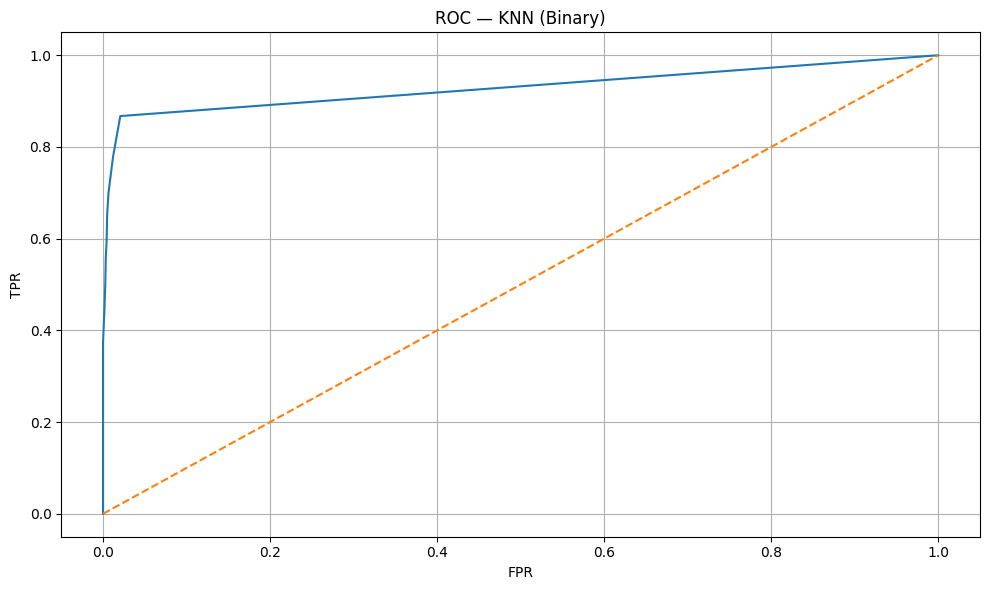

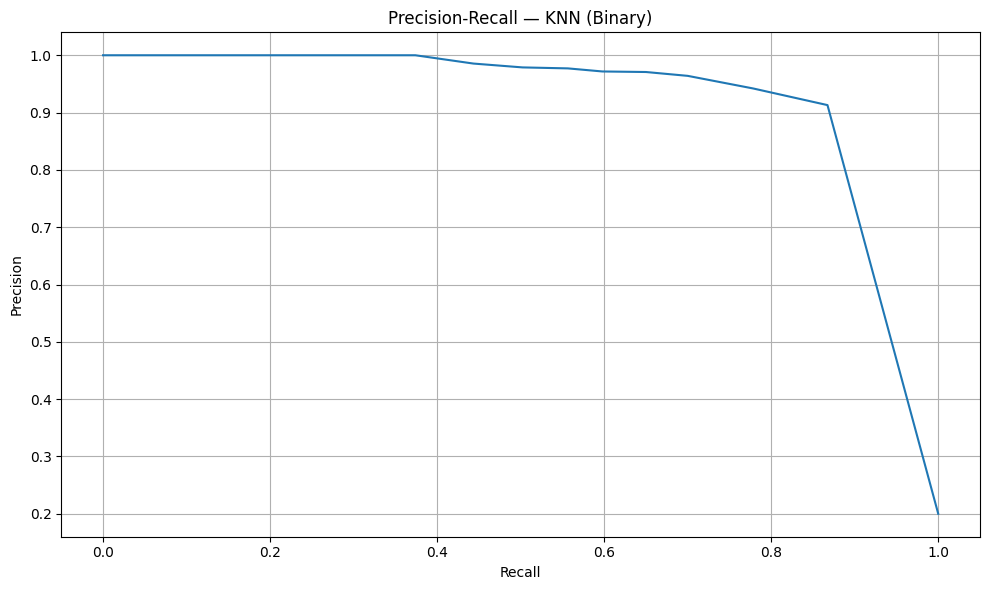

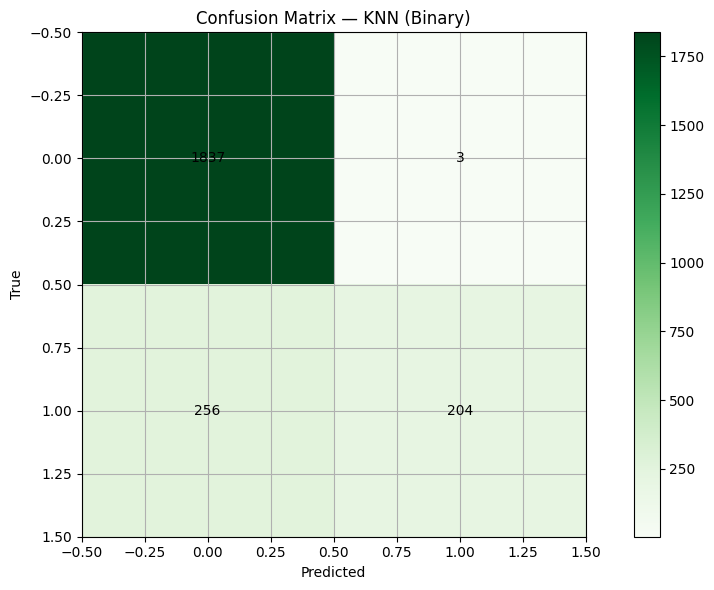

Classification Report — KNN (Binary)
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1840
           1       0.99      0.44      0.61       460

    accuracy                           0.89      2300
   macro avg       0.93      0.72      0.77      2300
weighted avg       0.90      0.89      0.87      2300

Training (binary): GaussianNB


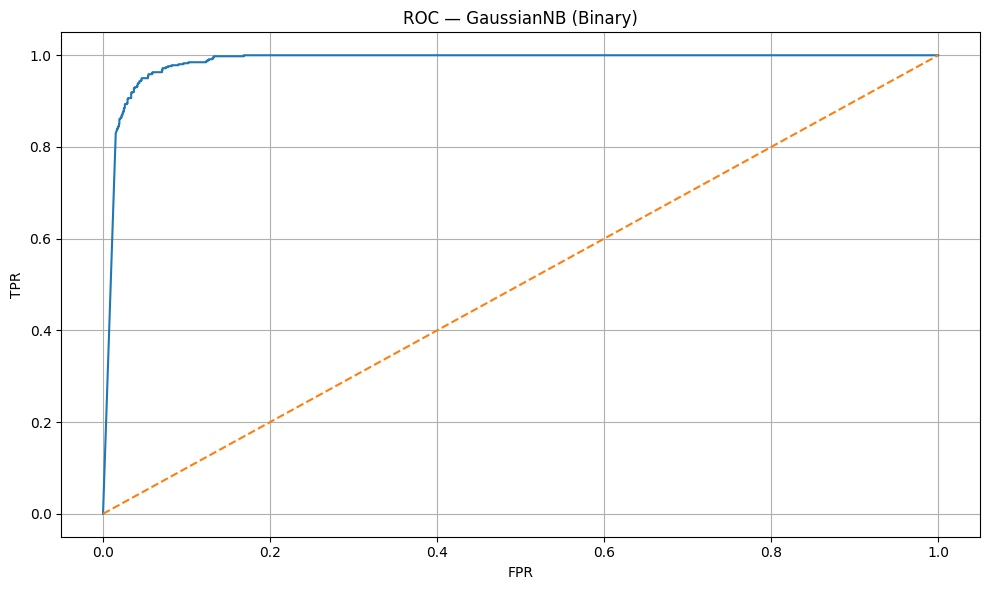

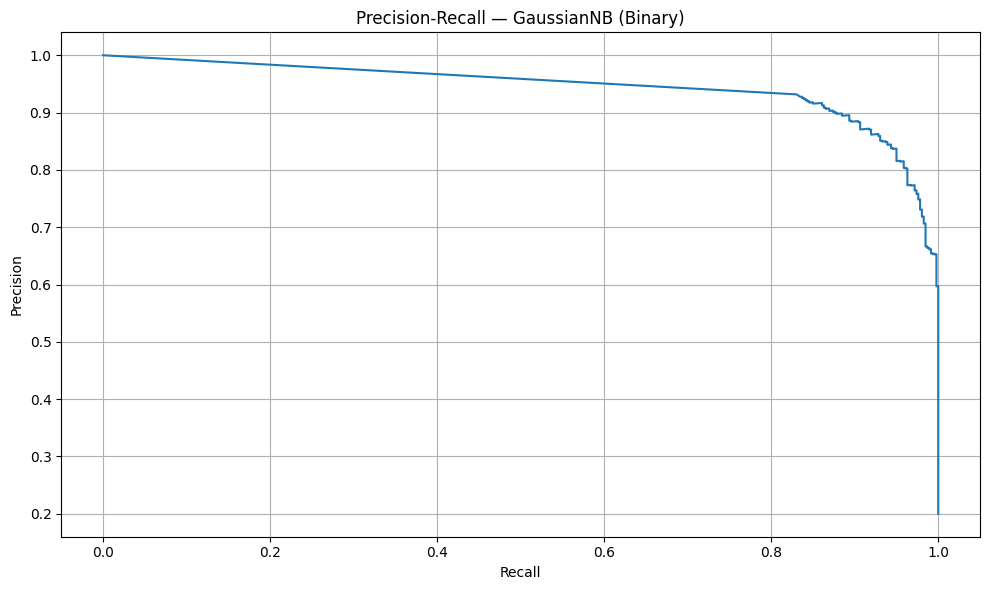

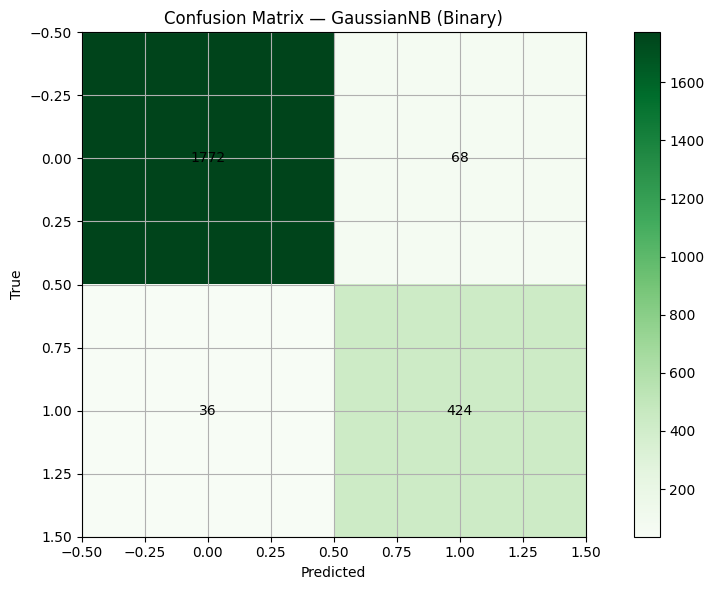

Classification Report — GaussianNB (Binary)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1840
           1       0.86      0.92      0.89       460

    accuracy                           0.95      2300
   macro avg       0.92      0.94      0.93      2300
weighted avg       0.96      0.95      0.96      2300



,Accuracy,Precision,Recall,F1,Balanced_Accuracy,MCC,Cohen_Kappa,ROC_AUC,Average_Precision
Model,,,,,,,,,
RandomForest,0.9748,0.9241,0.9522,0.9379,0.9663,0.9222,0.9221,0.9962,0.9867
GradientBoosting,0.9691,0.9332,0.9109,0.9219,0.9473,0.9028,0.9027,0.9947,0.9792
SVM_RBF,0.9665,0.9527,0.8761,0.9128,0.9326,0.8933,0.8921,0.9954,0.9819
GaussianNB,0.9548,0.8618,0.9217,0.8908,0.9424,0.8631,0.8623,0.9857,0.9168
KNN,0.8874,0.9855,0.4435,0.6117,0.7209,0.6176,0.5567,0.9291,0.8736
LogisticRegression,0.8057,1.0000,0.0283,0.0550,0.5141,0.1508,0.0445,0.5000,0.4542


Saved best binary model to: C:\Users\Srisha\AIDM SEM 3\MATH\project\outputs_seizure_ml\best_binary_RandomForest.joblib


In [12]:
# Use binary labels directly from preprocessed 'cleaned'
y_bin = cleaned['y'].values   # already 0/1 from preprocessing
X_bin = cleaned.drop(columns=['y']).values

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

models_binary = {
    "SVM_RBF": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", probability=True, random_state=42))]),
    "LogisticRegression": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "RandomForest": RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=15))]),
    "GaussianNB": GaussianNB()
}

def evaluate_binary(model, X_tr, y_tr, X_te, y_te, model_name=""):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_te)[:, 1]
    except Exception:
        pass

    metrics = {}
    metrics["Accuracy"] = accuracy_score(y_te, y_pred)
    pm, rm, fm, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
    metrics["Precision"] = pm; metrics["Recall"] = rm; metrics["F1"] = fm
    metrics["Balanced_Accuracy"] = balanced_accuracy_score(y_te, y_pred)
    metrics["MCC"] = matthews_corrcoef(y_te, y_pred)
    metrics["Cohen_Kappa"] = cohen_kappa_score(y_te, y_pred)

    if y_proba is not None:
        metrics["ROC_AUC"] = roc_auc_score(y_te, y_proba)
        metrics["Average_Precision"] = average_precision_score(y_te, y_proba)
        # ROC
        fpr, tpr, _ = roc_curve(y_te, y_proba)
        plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC — {model_name} (Binary)"); plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.tight_layout(); plt.show()
        # PR
        p, r, _ = precision_recall_curve(y_te, y_proba)
        plt.figure(); plt.plot(r, p)
        plt.title(f"Precision-Recall — {model_name} (Binary)"); plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.tight_layout(); plt.show()
    else:
        metrics["ROC_AUC"] = np.nan
        metrics["Average_Precision"] = np.nan

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(); plt.imshow(cm, cmap="Greens"); plt.colorbar()
    plt.title(f"Confusion Matrix — {model_name} (Binary)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout(); plt.show()

    print(f"Classification Report — {model_name} (Binary)")
    print(classification_report(y_te, y_pred, zero_division=0))
    return metrics, model

results_bin = []
fitted_bin = {}
for name, model in models_binary.items():
    print("="*80)
    print("Training (binary):", name)
    m, fitted = evaluate_binary(model, Xb_train, yb_train, Xb_test, yb_test, model_name=name)
    m["Model"] = name
    results_bin.append(m)
    fitted_bin[name] = fitted

results_bin_df = pd.DataFrame(results_bin).set_index("Model").sort_values(by="F1", ascending=False)
display(results_bin_df.round(4))

# Save best binary model
best_bin_name = results_bin_df.index[0]
best_bin_model = fitted_bin[best_bin_name]
bin_model_path = os.path.join(OUT_DIR, f"best_binary_{best_bin_name}.joblib")
dump(best_bin_model, bin_model_path)
print("Saved best binary model to:", bin_model_path)


In [15]:
original_cols = set(df_.columns)
final_cols = set(X_pca_df.columns).union({'y'})

dropped_cols = original_cols - final_cols
print("Dropped columns:", dropped_cols)


Dropped columns: {'X63', 'X60', 'X72', 'X128', 'X40', 'X50', 'X65', 'X18', 'X14', 'X102', 'X111', 'X156', 'X161', 'X39', 'X9', 'X157', 'X21', 'X173', 'X83', 'X56', 'X138', 'X146', 'X29', 'X30', 'X57', 'X46', 'X37', 'X52', 'X61', 'X67', 'X25', 'X89', 'X98', 'X169', 'X167', 'X134', 'X82', 'X155', 'X170', 'X71', 'X130', 'X112', 'X51', 'X41', 'X99', 'X74', 'X149', 'X143', 'X133', 'X150', 'X113', 'X139', 'X11', 'X153', 'X84', 'X1', 'X106', 'X19', 'X142', 'X144', 'X32', 'X151', 'X49', 'X76', 'X69', 'X64', 'X94', 'X103', 'X136', 'X137', 'X159', 'X119', 'X129', 'X162', 'X58', 'X77', 'X48', 'X78', 'X27', 'X148', 'X110', 'X59', 'X100', 'X12', 'X33', 'X117', 'X168', 'X114', 'X87', 'X35', 'X31', 'X28', 'X116', 'X23', 'X81', 'X160', 'X43', 'X97', 'X16', 'X20', 'X38', 'X66', 'X121', 'X108', 'X105', 'X127', 'X96', 'X75', 'X104', 'X92', 'X24', 'X178', 'X131', 'X88', 'X120', 'X126', 'X85', 'X55', 'X62', 'X147', 'X154', 'X163', 'X73', 'X80', 'X7', 'X22', 'X152', 'X95', 'X45', 'X164', 'X174', 'X44', 'X12

In [11]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def quick_cv(model, X, y, name=""):
    cv = cross_validate(model, X, y, cv=skf, scoring=["accuracy", "f1_macro"], n_jobs=-1)
    return pd.Series({"CV_Acc_mean": cv["test_accuracy"].mean(), "CV_F1_macro_mean": cv["test_f1_macro"].mean()})

cv_table = {}
for name, model in models_binary.items():
    cv_table[name] = quick_cv(model, X_train, y_train, name=name)
cv_table = pd.DataFrame(cv_table).T
display(cv_table.round(4))


,CV_Acc_mean,CV_F1_macro_mean
SVM_RBF,0.9653,0.9437
LogisticRegression,0.8110,0.5001
RandomForest,0.9732,0.9584
GradientBoosting,0.9702,0.9527
KNN,0.8700,0.7222
GaussianNB,0.9546,0.9301



Running XAI on best model: RandomForest


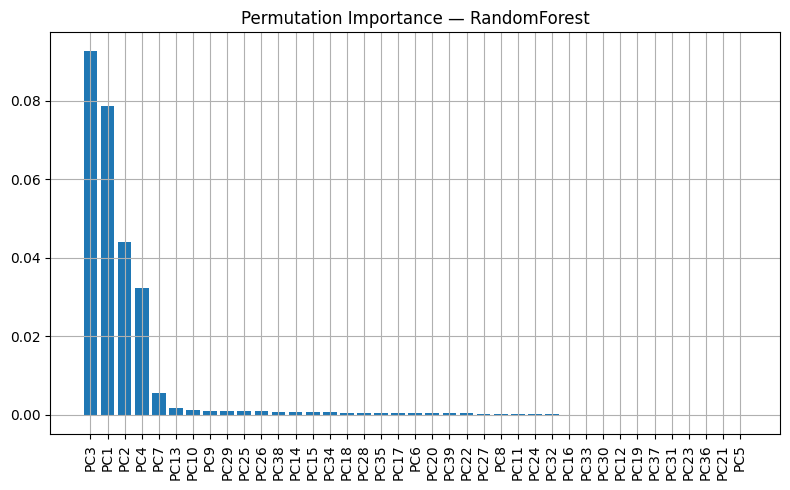

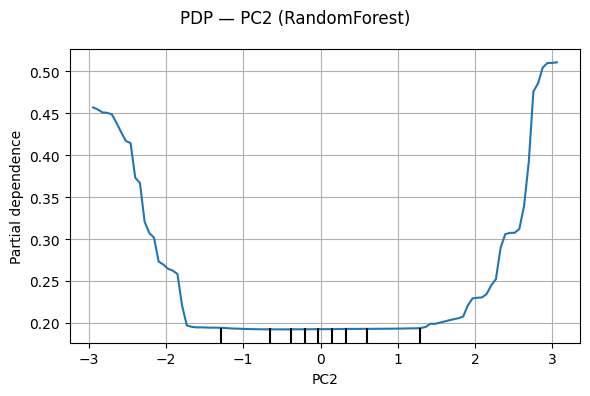

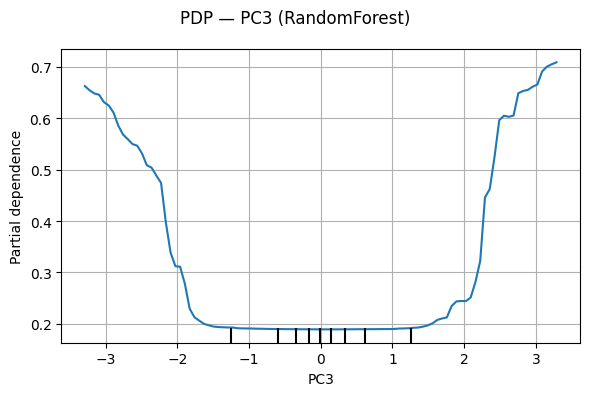

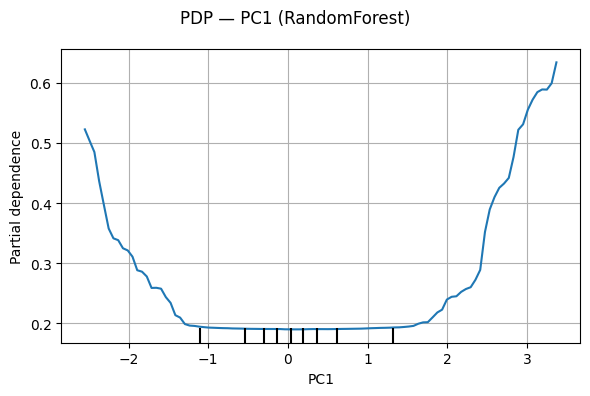

100%|===================| 4598/4600 [07:26<00:00]        

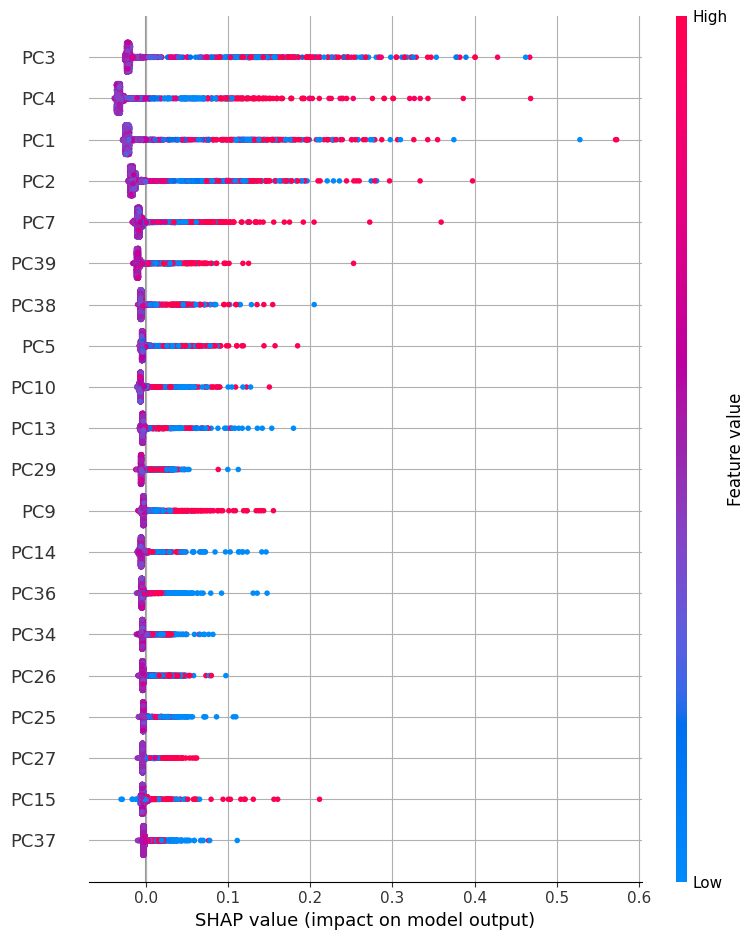

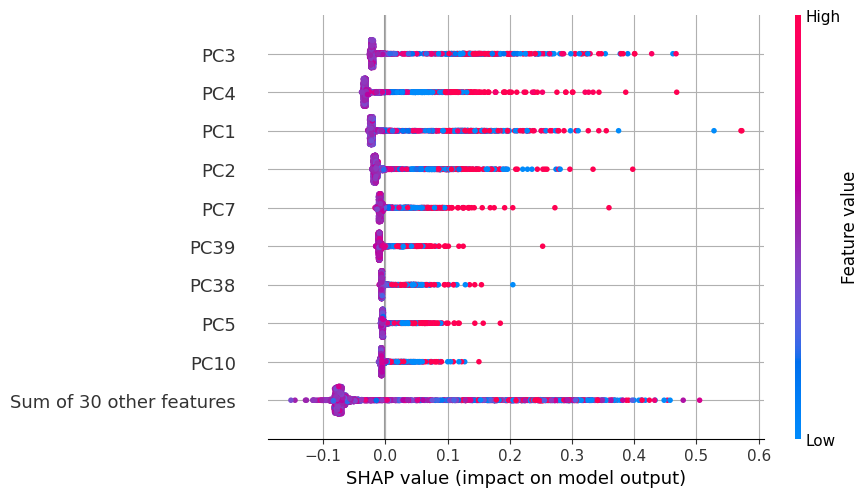

In [18]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
import numpy as np

# ========== PERMUTATION IMPORTANCE ==========
def plot_permutation_importance(model, X_te, y_te, feature_names, model_name):
    r = permutation_importance(model, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = r.importances_mean.argsort()[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(sorted_idx)), r.importances_mean[sorted_idx])
    plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.title(f"Permutation Importance — {model_name}")
    plt.tight_layout(); plt.show()


# ========== PARTIAL DEPENDENCE PLOTS ==========
def plot_pdp(model, X_te, feature_names, model_name, top_n=3):
    try:
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])
        else:
            importances = X_te.var(axis=0)  # fallback
        top_idx = np.argsort(importances)[-top_n:]
    except Exception:
        top_idx = range(min(top_n, X_te.shape[1]))

    for i in top_idx:
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(model, X_te, [i], feature_names=feature_names, ax=ax)
        plt.suptitle(f"PDP — {feature_names[i]} ({model_name})")
        plt.tight_layout(); plt.show()


# ========== SHAP ==========
def plot_shap(model, X_tr, X_te, feature_names, model_name):
    explainer = shap.Explainer(model, X_tr)
    shap_values = explainer(X_te)

    # Handle binary/multiclass
    if shap_values.values.ndim == 3:  
        shap_values = shap.Explanation(
            values=shap_values.values[:, :, 1],  # take class 1
            base_values=shap_values.base_values[:, 1],
            data=shap_values.data,
            feature_names=feature_names
        )

    # Summary plot
    shap.summary_plot(shap_values, features=X_te, feature_names=feature_names)

    # Beeswarm plot
    shap.plots.beeswarm(shap_values, max_display=10)

    # Force plot for one instance
    shap.plots.force(shap_values[0])


# ========== RUN XAI ON BEST MODEL ==========
feature_names = cleaned.drop(columns=['y']).columns.tolist()

print(f"\nRunning XAI on best model: {best_bin_name}")

# Permutation Importance
plot_permutation_importance(best_bin_model, Xb_test, yb_test, feature_names, best_bin_name)

# PDP
plot_pdp(best_bin_model, Xb_test, feature_names, best_bin_name, top_n=3)

# SHAP
plot_shap(best_bin_model, Xb_train, Xb_test, feature_names, best_bin_name)


In [17]:

results_multi_df.to_csv(os.path.join(OUT_DIR, "results_multiclass.csv"))
results_bin_df.to_csv(os.path.join(OUT_DIR, "results_binary.csv"))
print("Saved results to:", OUT_DIR)


Saved results to: C:\Users\Srisha\AIDM SEM 3\MATH\project\outputs_seizure_ml
